## assignment 3



### Exercise 1
1. Define your own function in Python that implements a Monte Carlo estimator for estimating $C_0$ and returns a Monte Carlo approximation for $C_0$, together with an asymptotic 95\% confidence interval (see page 30 of Lecture note). 
2. Compare your results to the analytical results obtained by using the Black-Scholes option pricing formula implemented in Worksheet 1. 

### Solution - Exercise 1

We first import all modules that we use in this notebook. Note that BlackScholes_Analytical is our own module that contains an implementation of the Black-Scholes option pricing formula (see BlackScholes_Analytical.py). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time


In [2]:
rng = np.random.default_rng(12345)

In [3]:
def terminal_stockprice(rng, s0, t, r, sigma, samplesize):
    """
    Function generates terminal stock price in Black-Scholes model.

    Parameters
    ----------
    rng : random._generator.Generator
        Generator object of numpy for generating random numbers
    s0 : float
        Initial stock price.
    t : float
        Terminal time at which stock price is generated.
    r : float
        Riskless interest rate.
    sigma : float
        Volatility.
    samplesize : int
        Sample size, i.e., number of times terminal stock price is generated.

    Returns
    -------
    stockprice : array
        Sample of terminal stock price in Black Scholes model.

    """
    mystandardnormalsample = rng.standard_normal(size=samplesize)
    tmp1 = (r - 0.5*(sigma ** 2)) * t
    tmp2 = sigma * np.sqrt(t) * mystandardnormalsample
    stockprice = s0 * np.exp(tmp1 + tmp2)
    return stockprice

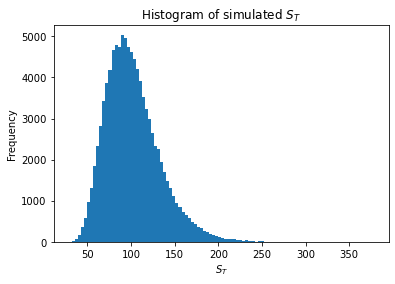

In [4]:
# Plotting a histogram of the terminal stock price
mystockprice = terminal_stockprice(rng, s0=100, t=1, r=0.02, sigma=0.3,
                                   samplesize=100000)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(mystockprice, bins=100)
ax.set_ylabel("Frequency")
ax.set_xlabel("$S_T$")
ax.set_title("Histogram of simulated $S_T$")
plt.show()

In [5]:
def bs_call_mc(rng, s0, k, t, r, sigma, samplesize, myepsilon):
    """
    Function computes time-0 price of European call price in Black-Scholes
    model by Monte Carlo.

    Parameters
    ----------
    rng : random._generator.Generator
        Generator object of numpy for generating random numbers
    s0 : float
        Initial stock price.
    t : float
        Terminal time at which stock price is generated.
    r : float
        Riskless interest rate.
    sigma : float
        Volatility.
    samplesize : int
        Sample size, i.e., number of times terminal stock price is generated.
    myepsilon : float
        1 - myepsilon is level of confidence for CI interval.

    Returns
    -------
    price : float
        Time-0 price of European call option in BS-model based on Monte Carlo.
    standarddev : float
        Standard deviation of random variable representing discounted payoff.
    ci_left : float
        Left boundary of 1-myepsilon confidence interval.
    ci_right : float
        Right boundary of 1-myepsilon confidence interval.
    """
    # Generate terminal stock prices.
    mystockprice = terminal_stockprice(rng, s0, t, r, sigma, samplesize)
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - k, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- r * t)*payoffs
    # Compute MC price
    price = np.mean(discountedpayoffs)
    # Compute confidence interval next
    standarddev_rv = np.std(discountedpayoffs, ddof=1)
    standarddev_mcest = standarddev_rv / np.sqrt(samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = price - aepsilon * standarddev_mcest
    # Right boundary of CI
    ci_right = price + aepsilon * standarddev_mcest
    return price, standarddev_mcest, ci_left, ci_right

In [6]:
# Defining some model parameters
S0 = 50.0
K = 50.0
T = 0.25
R = 0.05
Sigma = 0.3
Samplesize = 100000
Myepsilon = 0.05
mydig = 6

In [7]:
def black_scholes_call(st, t, k, T, r, sigma):
    d1 = (np.log(st / k) + (r + 0.5 * sigma**2) * (T-t))/(sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    tmp1 = st * norm.cdf(d1, loc=0, scale=1)
    tmp2 = k * np.exp(-r *(T-t)) * norm.cdf(d2, loc=0, scale=1)
    price = tmp1 - tmp2
    return price

In [8]:
myprice = black_scholes_call(S0, 0, K, T, R, Sigma)
print("Analytical price: ", round(myprice, mydig))
print("----------------")
MCresults = bs_call_mc(rng, S0, K, T, R, Sigma, 2*Samplesize, Myepsilon)
print("MC price: ", round(MCresults[0], mydig), ", stdev of MC est: ",
      round(MCresults[1], mydig))
print("CI based on MC is (", round(MCresults[2], mydig), ", ",
      round(MCresults[3], mydig), "). ")

Analytical price:  3.291542
----------------
MC price:  3.289196 , stdev of MC est:  0.011158
CI based on MC is ( 3.267327 ,  3.311065 ). 


Hence, we see that the MC price is very close to the analytical price. Here, for this specific realisation of random variables the confidence interval based on the MC estimator contains the analytical price. 

### Exercise 2 
1. Write Python code that implements an  antithetic variates estimator for $C_0$ using the antithetic pair $(X, -X)$ where  $X\sim \mathcal{N}_1(0, 1)$. 
2. Write Python code that computes the variance of your antithetic variate estimator. 

### Solution - Exercise 2

We consider the antithetic pair $(X, -X)$ where  $X\sim \mathcal{N}_1(0, 1)$. For the stock price this implies that we consider pairs of the form $(S^{(1)}, S^{(2)})$, where
\begin{align*}
S^{(1)} & = S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} X), \\
S^{(2)} & = S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} (-X)) 
\end{align*}
and we will use them to compute the corresponding discounted payoffs. 


In [9]:
def terminal_stockprice_av(rng, s0, t, r, sigma, samplesize):
    """Function computes terminal stock prices based on antithetic pairs. """
    mynormals1 = rng.standard_normal(samplesize)
    mynormals2 = - mynormals1
    tmp1 = (r - 0.5*sigma ** 2) * t
    tmp2 = sigma * np.sqrt(t) * mynormals1
    tmp3 = sigma * np.sqrt(t) * mynormals2
    stockprice1 = s0 * np.exp(tmp1 + tmp2)
    stockprice2 = s0 * np.exp(tmp1 + tmp3)
    allstockprices = np.concatenate((stockprice1, stockprice2))
    return stockprice1, stockprice2, allstockprices

In [10]:
def bs_call_av(rng, s0, k, t, r, sigma, samplesize, myepsilon):
    """ Antithethic variate estimation for European call price in BS model."""
    # Note that 2*samplesize random variables will be used in the AV estimator.
    # Generate terminal stock prices.
    mystockprices = terminal_stockprice_av(rng, s0, t, r, sigma, samplesize)
    # Compute payoffs.
    payoffs1 = np.maximum(mystockprices[0] - k, 0)
    payoffs2 = np.maximum(mystockprices[1] - k, 0)
    # Discount payoffs
    discpayoffs1 = np.exp(- r * t)*payoffs1
    discpayoffs2 = np.exp(- r * t)*payoffs2
    thecov = np.cov(discpayoffs1, discpayoffs2, ddof=1)[0, 1]
    possiblereduction = thecov / (2 * samplesize)
    discpayoffs = np.concatenate((discpayoffs1, discpayoffs2))
    price = np.mean(discpayoffs)
    standarddev_rv = np.std(discpayoffs, ddof=1)
    standarddev_avest = standarddev_rv / np.sqrt(2*samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    ci_left = price - aepsilon * standarddev_avest
    ci_right = price + aepsilon * standarddev_avest
    return price, standarddev_avest, ci_left, ci_right, possiblereduction

In [11]:
print("----------------")
AVresults = bs_call_av(rng, S0, K, T, R, Sigma, Samplesize, Myepsilon)
print("AV price: ", round(AVresults[0], mydig), ", stdev of AV est: ",
      round(AVresults[1], mydig))
print("CI based on AV is (", round(AVresults[2], mydig), ", ",
      round(AVresults[3], mydig), "). ")
print("Note that sample covariance/(2n) is ", AVresults[4])

----------------
AV price:  3.296327 , stdev of AV est:  0.011175
CI based on AV is ( 3.274424 ,  3.31823 ). 
Note that sample covariance/(2n) is  -5.432877334136868e-05


We see that the AV estimate is very close to the analytical option price. In this example, we see that $cov(Z^{(1)}, Z^{(2)})/2n$, where
\begin{align*}
Z^{(1)}& = e^{-rT} \left(S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} X) - K \right)^+, \\
Z^{(2)}& = e^{-rT} \left(S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} (-X)) - K \right)^+, 
\end{align*}
is negative but very close to zero. This explains the reason why the variance reduction is not significant for this example (see page 42 of lecture note). 

### Exercise 3 
1. Write Python code that uses a control variates estimator with the discounted stock price as control as discussed in the lecture: Let $S_i$ be i.i.d. samples with the same distribution as $S_T$ and $Y_i = e^{-rT} (S_i - K)^+$. Then the control variate estimator is given by
\begin{align*}
	\overline{Y}_n(b) = \frac{1}{n} \sum_{i=1}^n (Y_i - b(e^{-r T}S_i - S(0))),
\end{align*}
where $b$ might be replaced by $\hat{b}_n^*$ (see lecture notes for the definition). 
2. Write Python code that computes the variance of the control variate estimator $\overline{Y}_n(\hat{b}_n^*)$ considered above. 
3. The effectiveness of the control variate depends heavily on the strike $K$. Compute a sample estimate for $\rho^2_{XY}$, i.e., the squared correlation between $X=e^{-rT} S_T$ and $Y= e^{-rT} (S_T - K)^+$, for different values of the strike $K$ and present a plot that shows  $\rho^2_{XY}$ as a function in $K$. 

### Solution - Exercise 3

In [12]:
def bs_call_cv(rng, s0, k, t, r, sigma, samplesize, myepsilon):
    """ Control variate estimation for European call price in BS model."""
    # Generate terminal stock prices.
    mystockprice = terminal_stockprice(rng, s0, t, r, sigma, samplesize)
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - k, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- r * t)*payoffs
    # Use discounted stock as control
    xs = np.exp(- r * t) * mystockprice
    # Compute sample version of b*
    bstar = np.cov(xs, discountedpayoffs, ddof=1)[0, 1] / np.var(xs, ddof=1)
    # print("In cv bstar=", bstar)
    # Define z= Y(bstar)
    z = discountedpayoffs - bstar * (xs - s0)
    # Compute MC price
    price = np.mean(z)
    # Compute confidence interval next
    standarddev_rv = np.std(z, ddof=1)
    standarddev_cvest = standarddev_rv / np.sqrt(samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = price - aepsilon * standarddev_cvest
    # Right boundary of CI
    ci_right = price + aepsilon * standarddev_cvest
    # Compute the sqared correation rhosquared
    tmpcov = np.cov(xs, discountedpayoffs, ddof=1)[0, 1]
    tmpvarx = np.var(xs, ddof=1)
    tmpvary = np.var(discountedpayoffs, ddof=1)
    rhosquared = (tmpcov ** 2) / (tmpvarx * tmpvary)
    return price, standarddev_cvest, ci_left, ci_right, rhosquared

In [13]:
print("----------------")
CVresults = bs_call_cv(rng, S0, K, T, R, Sigma, 2*Samplesize, Myepsilon)
print("CV price: ", round(CVresults[0], mydig), ", stdev of CV est: ",
      round(CVresults[1], mydig))
print("CI based on CV is (", round(CVresults[2], mydig), ", ",
      round(CVresults[3], mydig), "). ")
print("Note that rhosquared is ", CVresults[4])

----------------
CV price:  3.286386 , stdev of CV est:  0.00496
CI based on CV is ( 3.276664 ,  3.296107 ). 
Note that rhosquared is  0.8029563078024153


Also the CV estimate is very close to the analytical price. The standard deviation of the CV estimator is much smaller than the standard deviation of the MC estimator. 

### Sensitivity of the correlation in the CV estimator with respect to the strike

In [14]:
"""
We consider the sensitivity of rho and rhosquared related to the control
variate estimator with respect to the strike price.
We consider the same model parameters as in Glasserman(2004; p. 189) and will reproduce the results reported there. 
"""

S0 = 50
T = 0.25
R = 0.05
Sigma = 0.3
Samplesize = 100000


numberofk = 100
strikes = np.linspace(start=0, stop=80, num=numberofk)
rhosquared = np.zeros(numberofk)
rho = np.zeros(numberofk)

In [15]:
# Generate stockprice
myst = terminal_stockprice(rng, S0, T, R, Sigma, Samplesize)
mystockprice = myst

for i in range(numberofk):
    k = strikes[i]
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - k, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- R * T)*payoffs
    # Define variable y for control variate estimator
    ys = discountedpayoffs
    # Use discounted stock as control
    xs = np.exp(- R * T) * mystockprice
    rho[i] = np.corrcoef(xs, ys)[0, 1]
    rhosquared[i] = rho[i] ** 2

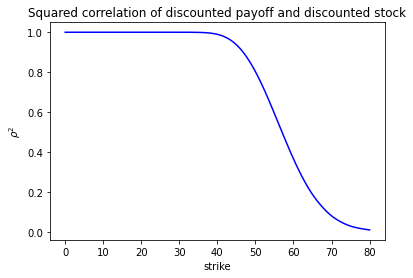

In [16]:
plt.plot(strikes, rhosquared, c="blue")
plt.xlabel("strike")
plt.ylabel(r"$\rho^2$")
plt.title("Squared correlation of discounted payoff and discounted stock")
plt.show()

Hence, we see that for small strikes there is a strong correlation between the discounted payoff and the discounted stock price, but this decreases significantly for larger strikes. 

In [17]:
# Next we compare the standarddeviation of the MC and the CV estimator
stdMC = np.zeros(numberofk)
stdCV = np.zeros(numberofk)

# Generate the terminal stock prices
mystockprice = terminal_stockprice(rng, S0, T, R, Sigma, Samplesize)

for i in range(numberofk):
    k = strikes[i]
    # Compute discounted payoffs
    discountedpayoffs = np.exp(- R * T) * np.maximum(mystockprice - k, 0)
    # Compute standard dev of MC estimator 
    stdMC[i] = np.std(discountedpayoffs, ddof=1) / np.sqrt(Samplesize)

    # Use discounted stock as control
    xs = np.exp(- R * T) * mystockprice
    # Compute sample version of b*
    bstar = np.cov(xs, discountedpayoffs, ddof=1)[0, 1] / np.var(xs, ddof=1)
    # Define z= Y(bstar)
    z = discountedpayoffs - bstar * (xs - S0)
    # Compute standard dev of CV estimator 
    stdCV[i] = np.std(z, ddof=1) / np.sqrt(Samplesize)




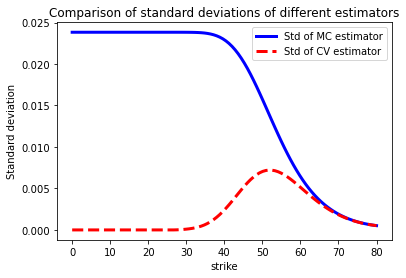

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(strikes, stdMC, lw=3, c="blue", label="Std of MC estimator")
ax.plot(strikes, stdCV, lw=3, c="red", label="Std of CV estimator", linestyle = "dashed")
ax.set_ylabel("Standard deviation")
ax.set_xlabel("strike")
ax.set_title("Comparison of standard deviations of different estimators")
ax.legend(loc = "upper right")
plt.show()

Hence, we see that for our model parameters for small strikes, the standard deviation of the control variate estimator is significantly smaller than the standard deviation of the Monte Carlo estimator. For larger strikes, the standard deviations of the two estimators are very similar and overall on a rather low level. The standard deviation of the MC estimator is highest for small strikes and for those the squared correlation between the discounted payoff and the discounted stock price is highest (see above), showing that there are great benefits of using a CV estimator rather than a standard MC estimator for small strike prices.   

## Insurance portfolio loss   under a  compound Poisson model

The losses  of an insurance portfolio $A$ is of the form:
$$L_A =\sum_{i=1}^{N_A} X_i, 
$$
where $N_A$ is a Poisson random variable with parameter $10$,
$X_i$ are i.i.d log-normal random variables   with parameters 2 and $\sqrt{8}$ 
(8 is the variance  of the underlying normal).
The losses  of another (independent of $A$) insurance portfolio $B$ is of the form:
$$L_B =\sum_{i=1}^{N_B} Y_i, 
$$
where $N_B$ is a Poisson random variable with parameter $10$,
and $Y_i$ are i.i.d log-normal  random
variables  with parameter 0 and $\sqrt{12}$.


We apply   the  Monte Carlo approach  to approximate the  probability
$L_0=\mathbb{P}(L_A> L_B)$.



### Exercise 4
1.  Implement a Monte Carlo estimator for estimating $L_0$,  which  returns a Monte Carlo approximation for $L_0$, together with an asymptotic 95\% confidence interval. 

<!-- 2. Implement an antithetic variates estimator for $L_0$ and	compute the variance of your antithetic variate estimator. -->

2. Can you write a more efficient implementation without looping over the sample size?


In [19]:
# Defining some model parameters
Lambda = 10.0
MuA = 2.0
SigmaA = np.sqrt(8)
MuB = 0.0  
SigmaB = np.sqrt(12) 
Samplesize = 100000
Myepsilon = 0.05
mydig = 6

The following table illustrates a sample of Compound Poisson random variables with  size $n$:

|Number of claims | Claim 1 | Claim 2 | Claim 3 | ...|Total loss|
|:---:| :---: | :---: | :---: | :---:| :---: |
|$N^{(1)}=2$|  $X^{(1)}_1$ | $X^{(1)}_2$ |  | |$L^{(1)}$ |
|$N^{(2)}=3$|  $X^{(2)}_1$ | $X^{(2)}_2$ |$X^{(2)}_3$  ||$L^{(2)}$ |
|$\vdots$| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ |
|$N^{(n)}=1$|  $X^{(n)}_1$ |  | |  |  $L^{(n)}$|


In [20]:
def mycompoundPoisson(rng, Lambda, mu, sigma, samplesize):
    myPoissonsample = rng.poisson(lam=Lambda, size=samplesize)
    myCompoundPossionSample = np.zeros(samplesize)
    for i in range(samplesize):
        myCompoundPossionSample[i] = np.sum(np.exp(mu + sigma * rng.standard_normal(size=myPoissonsample[i])))
        
    return myCompoundPossionSample


def portfolio_loss(rng, Lambda, muA, sigmaA, muB, sigmaB, samplesize, myepsilon):
    """
    Monte Carlo estimations for portfolio losses in compounded Poisson model.

    """
 

    loss_sign = np.zeros(samplesize)
    
    lossA = mycompoundPoisson(rng, Lambda, muA, sigmaA, samplesize)
    lossB = mycompoundPoisson(rng, Lambda, muB, sigmaB, samplesize)
    loss_sign = (lossA > lossB) * 1
    
    # Compute MC estimator and confidence interval 
    mean_difference = np.mean(loss_sign)
    standarddev_rv = np.std(loss_sign, ddof=1)
    standarddev_mcest = standarddev_rv / np.sqrt(samplesize)
    
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = mean_difference - aepsilon * standarddev_mcest
    # Right boundary of CI
    ci_right = mean_difference + aepsilon * standarddev_mcest
    return mean_difference, standarddev_mcest, ci_left, ci_right
    

In [24]:

start = time.time()
MCresults = portfolio_loss(rng, Lambda, MuA, SigmaA, MuB, SigmaB, Samplesize, Myepsilon)

runtime = time.time()-start

print("----------------")
print("MC loss: ", round(MCresults[0], mydig), ", stdev of MC est: ",
      round(MCresults[1], mydig))
print("CI based on MC is (", round(MCresults[2], mydig), ", ",
      round(MCresults[3], mydig), "). ")
print("Computation time is ", runtime)

----------------
MC loss:  0.67768 , stdev of MC est:  0.001478
CI based on MC is ( 0.674783 ,  0.680577 ). 
Computation time is  2.3612632751464844


Apply a shrinking sampling techinique to avoid looping over sample sizes

In [22]:
def mycompoundPoisson_shrinking(rng, Lambda, mu, sigma, samplesize):
    myPoissonsample = rng.poisson(lam=Lambda, size=samplesize)
    myCompoundPossionSample = np.zeros(samplesize)
    for i in range(np.max(myPoissonsample)):
        idx = (myPoissonsample >= i)
        myCompoundPossionSample [idx] += np.exp(mu + sigma * rng.standard_normal(size=np.sum(idx)))
        
    return myCompoundPossionSample

def portfolio_loss_shrinking(rng, Lambda, muA, sigmaA, muB, sigmaB, samplesize, myepsilon):
    """
    Monte Carlo estimations for portfolio losses in compounded Poisson model.

    """
 

    loss_sign = np.zeros(samplesize)
    
    lossA = mycompoundPoisson_shrinking(rng, Lambda, muA, sigmaA, samplesize)
    lossB = mycompoundPoisson_shrinking(rng, Lambda, muB, sigmaB, samplesize)
    loss_sign = (lossA > lossB) * 1
    
    # Compute MC estimator and confidence interval 
    mean_difference = np.mean(loss_sign)
    standarddev_rv = np.std(loss_sign, ddof=1)
    standarddev_mcest = standarddev_rv / np.sqrt(samplesize)
    
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = mean_difference - aepsilon * standarddev_mcest
    # Right boundary of CI
    ci_right = mean_difference + aepsilon * standarddev_mcest
    return mean_difference, standarddev_mcest, ci_left, ci_right


In [25]:
start = time.time()
MCresults = portfolio_loss_shrinking(rng, Lambda, MuA, SigmaA, MuB, SigmaB, Samplesize, Myepsilon)

runtime = time.time()-start

print("----------------")
print("MC loss: ", round(MCresults[0], mydig), ", stdev of MC est: ",
      round(MCresults[1], mydig))
print("CI based on MC is (", round(MCresults[2], mydig), ", ",
      round(MCresults[3], mydig), "). ")
print("Computation time with shrinking sampling is ", runtime)

----------------
MC loss:  0.6798 , stdev of MC est:  0.001475
CI based on MC is ( 0.676908 ,  0.682692 ). 
Computation time with shrinking sampling is  0.10666179656982422
